# Produisez une étude de marché

## Preamble

### Notebook config

In [28]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from pandas.plotting import scatter_matrix
from scipy import stats
import seaborn as sns
from cycler import cycler

### My functions

In [29]:
# Functions
def eta_squared(x,y):
    """Calculate the Eta Squared of two variables."""
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

def annual_growth(x, y):
    return (y/x - 1) * 100

### My styles

In [64]:
plt.style.use('ggplot')

fig_size = [10.,6]
params = {'axes.labelsize': 12,
          'axes.prop_cycle': cycler('color', ['#0F5499', '#00994D', '#96CC28', '#CC0000', '#FF7FAA']),
#          'axes.facecolor': '#FFF1E5',
#          'axes.edgecolor': '#FFF1E5',
          'axes.titlesize': '14',
          'lines.linewidth': '2',
          'figure.titleweight': 'bold',
          'font.size':   14,
          'text.color': 'black',
          'legend.fontsize': 10,
          'xtick.labelsize': 7,
          'ytick.labelsize': 7,
          'axes.grid.axis': 'x',
          'grid.color': '#807973',
          'grid.linewidth': '1',
          'grid.alpha': '0.5',
          'text.usetex': False,
          # boxplots
          'boxplot.medianprops.color': 'black',
 #         'figure.facecolor': '#FFF1E5',
          'figure.figsize': fig_size,
}

plt.rcParams.update(params)

# plt.rcParams.keys()

## Chargement des données

In [36]:
df = pd.read_csv("Socle.csv")
df = df[["Area Code", "Area", "Element Code", "Element", "Item Code", "Item", "Year", "Value"]]
df.columns = ["area_code", "area", "element_code", "element", "item_code", "item", "year", "value"]
df = df[(df.element_code == 511) | (df.year == 2017)]
df = df.replace("Total Population - Both sexes", "population")

popIndex = df[df.year == 2017].groupby('element_code').get_group(511).index

for row in popIndex:
    y = df['value'].loc[row]
    x = df['value'].loc[row-1]
    df['value'].loc[row-1] = annual_growth(x ,y)

In [37]:
ix = df[(df.year == 2016)].index
df['element'].loc[ix] = 'population_annual_growth'
ix = df[(df.item_code == 2901) & (df.element_code == 664)].index
df['element'].loc[ix] = "kcal_capita_a_day"
ix = df[(df.item_code == 2901) & (df.element_code == 674)].index
df['element'].loc[ix] = "protein_g_capita_a_day"
ix = df[(df.item_code == 2941) & (df.element_code == 664)].index
df['element'].loc[ix] = "animal_kcal_capita_a_day"
ix = df[(df.item_code == 2941) & (df.element_code == 674)].index
df['element'].loc[ix] = "animal_protein_g_capita_a_day"

In [38]:
df = df[['area', 'element', 'value']].pivot_table(index=['area'], columns=['element'], values=['value'])
df.columns = df.columns.droplevel()
df['share_of_protein'] = df['animal_protein_g_capita_a_day'] / df['protein_g_capita_a_day']

In [39]:
df

element,animal_kcal_capita_a_day,animal_protein_g_capita_a_day,kcal_capita_a_day,population,population_annual_growth,protein_g_capita_a_day,share_of_protein
area,,,,,,,
Afghanistan,191.0,10.55,2000.0,36296.11,2.580559,54.09,0.195045
Albania,1094.0,66.34,3400.0,2884.17,-0.078644,119.55,0.554914
Algeria,404.0,25.71,3349.0,41389.19,2.066020,92.91,0.276719
Angola,213.0,16.48,2270.0,29816.77,3.377933,54.11,0.304565
Antigua and Barbuda,747.0,54.06,2430.0,95.43,0.952079,81.45,0.663720
Argentina,971.0,65.69,3239.0,43937.14,0.985280,102.71,0.639568
Armenia,790.0,44.57,3078.0,2944.79,0.294604,97.37,0.457739
Australia,1034.0,71.30,3311.0,24584.62,1.326769,108.10,0.659574
Austria,1153.0,64.88,3692.0,8819.90,0.829970,108.13,0.600018


In [40]:
gdp = pd.read_csv("GDP_per_capita.csv")
gdp = gdp[["Area", "Element", "Value"]]
gdp.columns = ['area', 'element', 'value']
gdp = gdp.pivot_table(index=['area'], columns=['element'], values=['value'])
gdp.columns = gdp.columns.droplevel()
gdp.columns = ['gdp_growth', 'gdp_capita']

Nous ne travaillons qu'avec les pays pour lesquels nous disposons de données alimentaires

In [41]:
# Liste des pays pour lesquels nous ne dispons pas de toutes les données alimentaires
temp = pd.merge(df, gdp, left_index=True, right_index=True, how='right')
excluded_countries = temp[temp.isna().any(axis=1)].index.tolist()
print(excluded_countries)

['Andorra', 'Anguilla', 'Aruba', 'Bahrain', 'Bermuda', 'Bhutan', 'British Virgin Islands', 'Brunei Darussalam', 'Burundi', 'Cayman Islands', 'Comoros', 'Cook Islands', 'Democratic Republic of the Congo', 'Equatorial Guinea', 'Eritrea', 'Greenland', 'Kosovo', 'Libya', 'Liechtenstein', 'Marshall Islands', 'Micronesia (Federated States of)', 'Monaco', 'Montserrat', 'Nauru', 'Palau', 'Palestine', 'Papua New Guinea', 'Puerto Rico', 'Qatar', 'San Marino', 'Seychelles', 'Singapore', 'Somalia', 'South Sudan', 'Syrian Arab Republic', 'Tonga', 'Turks and Caicos Islands', 'Tuvalu']


Ces pays sont: soit des paradis fiscaux, soit des pays en guerre, soit en situation d'instabilité politique peu propice au commerce.

In [42]:
temp = pd.merge(df, gdp, left_index=True, right_index=True, how='left')
temp[temp.isna().any(axis=1)]

,animal_kcal_capita_a_day,animal_protein_g_capita_a_day,kcal_capita_a_day,population,population_annual_growth,protein_g_capita_a_day,share_of_protein,gdp_growth,gdp_capita
area,,,,,,,,,
China,726.0,40.44,3194.0,1452625.24,0.491262,101.35,0.399013,NaN,NaN
"China, Taiwan Province of",652.0,42.46,2976.0,23674.55,0.238587,85.75,0.495160,NaN,NaN


In [49]:
df = pd.merge(df, gdp, left_index=True, right_index=True, how='left')
df[df.index.str.startswith("China")]

,animal_kcal_capita_a_day,animal_protein_g_capita_a_day,kcal_capita_a_day,population,population_annual_growth,protein_g_capita_a_day,share_of_protein,gdp_growth,gdp_capita
area,,,,,,,,,
"China, Hong Kong SAR",1360.0,101.11,3358.0,7306.32,0.866703,137.93,0.733053,5.580849,46390.334337
"China, Macao SAR",1009.0,67.08,3002.0,622.59,1.590954,100.46,0.667728,9.288741,80892.811251
"China, Taiwan Province of",652.0,42.46,2976.0,23674.55,0.238587,85.75,0.495160,NaN,NaN
"China, mainland",724.0,40.08,3197.0,1421021.79,0.493083,101.42,0.395188,8.886676,8682.249561


- Nous suprimons l'enregistrement de la Chine (aggrégation des données de la chine continentale et de ses territoires) et nous conservons les provinces et territoires de Hong Kong, Macao et Taiwan dont les données économiques et alimentaires sont suffisament distinctes.
- Nous récupérons le PIB de Taiwan bien qu'également un territoire "dépendant" et bénéficiant d'une reconnaissance internationnale limitée (http://bit.ly/3bLHRjq).
- Enfin, nous en profitons pour exclure la France de notre jeu de données puisuqe notre étude concerne le développemet à l'international d'une entreprise française.

In [51]:
# Suppression de la Chine
df = df[df.index != "China"]
# Suppression de la France
df = df[df.index != "France"]
# Taiwan GDP per capita
df.loc["China, Taiwan Province of"]['gdp_capita'] = 24480
df.loc["China, Taiwan Province of"]['gdp_growth'] = 8.027007
df[df.index.str.startswith("China")]

,animal_kcal_capita_a_day,animal_protein_g_capita_a_day,kcal_capita_a_day,population,population_annual_growth,protein_g_capita_a_day,share_of_protein,gdp_growth,gdp_capita
area,,,,,,,,,
"China, Hong Kong SAR",1360.0,101.11,3358.0,7306.32,0.866703,137.93,0.733053,5.580849,46390.334337
"China, Macao SAR",1009.0,67.08,3002.0,622.59,1.590954,100.46,0.667728,9.288741,80892.811251
"China, Taiwan Province of",652.0,42.46,2976.0,23674.55,0.238587,85.75,0.495160,8.027007,24480.000000
"China, mainland",724.0,40.08,3197.0,1421021.79,0.493083,101.42,0.395188,8.886676,8682.249561


Nous rejetons les colonnes dont nous n'avons plus besoin.

In [56]:
df = df.drop('animal_kcal_capita_a_day', axis=1)
df = df.drop('animal_protein_g_capita_a_day', axis=1)
df

,kcal_capita_a_day,population,population_annual_growth,protein_g_capita_a_day,share_of_protein,gdp_growth,gdp_capita
area,,,,,,,
Afghanistan,2000.0,36296.11,2.580559,54.09,0.195045,6.012664,618.989990
Albania,3400.0,2884.17,-0.078644,119.55,0.554914,9.581110,4450.008107
Algeria,3349.0,41389.19,2.066020,92.91,0.276719,2.833721,4055.246580
Angola,2270.0,29816.77,3.377933,54.11,0.304565,21.022534,4247.411049
Antigua and Barbuda,2430.0,95.43,0.952079,81.45,0.663720,2.043258,14803.010927
Argentina,3239.0,43937.14,0.985280,102.71,0.639568,13.791630,14399.621069
Armenia,3078.0,2944.79,0.294604,97.37,0.457739,9.181327,3936.798582
Australia,3311.0,24584.62,1.326769,108.10,0.659574,6.558313,57613.226228
Austria,3692.0,8819.90,0.829970,108.13,0.600018,5.499408,47717.728647


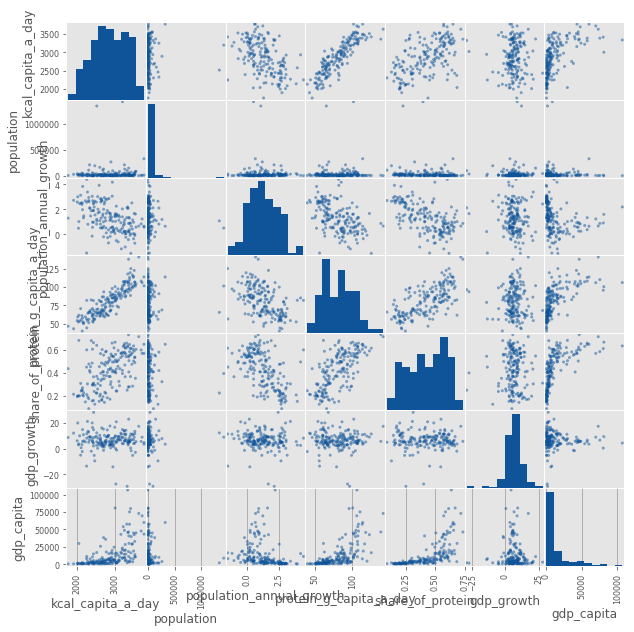

In [65]:
#graphique - croisement deux à deux des variables
scatter_matrix(df,figsize=(10,10))
plt.savefig("test.png")
plt.show()